# Equilibrium Diagram of a Box Beam under Uniaxial Compression

***

In our previous notebook we showed that the application of a bending load to a box beam results in an asymmetry of the internal loads about the midplane of the top skin. We consider this to be the cause of the bifurcation break observed for both the [unreinforced](06_Nonlinear_Buckling_Method_Verification.ipynb) and the [reinforced box beam](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb#nonlinear-buckling-method-verification). To prove that the bending load is responsible for the bifurcation break, in this notebook we are going to investigate the equilibrium diagram of the box beam under a uniaxial compression, where we expect to see the bifurcation restored. We are going to investigate this for both the unreinforced and the reinforced box beam configurations.

* [Unreinforced box beam](#unreinforced)
    * [Setup of the numerical model](#unreinforced-numerical-model)
    * [Linear buckling analysis](#unreinforced-linear-buckling)
    * [Nonlinear analysis](#unreinforced-nonlinear-analysis)
* [Reinforced box beam](#reinforced)
    * [Setup of the numerical model](#reinforced-numerical-model)
    * [Linear buckling analysis](#reinforced-linear-buckling)
    * [Nonlinear analysis](#reinforced-nonlinear-analysis)
* [Conclusions](#conclusions)


## Unreinforced box beam <a name="unreinforced"></a>

***

### Setup of the numerical model <a name="unreinforced-numerical-model"></a>

We consider an unreinforced box beam with the same geometry as the one used in our previous notebooks.

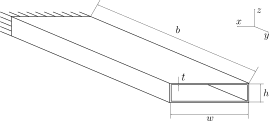

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

In [2]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.2f} m\n- span: {b/1e3:.2f} m\n- height: {h/1e3:.2f} m\n- wall thickness: {t:.2f} mm')

Box beam dimensions:
- width: 1.00 m
- span: 4.50 m
- height: 0.20 m
- wall thickness: 4.00 mm


We do the same for the material properties.

In [3]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

We create a mesh of quadrilateral elements using the function `mesh_box_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 86 mm based on the results of a previous [mesh convergence study](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb).

In [4]:
from resources import box_beam_utils

edge_length = 86  # [mm]
unreinforced_box_beam_mesh = box_beam_utils.mesh_box_pyvista(width=w, span=b, height=h, edge_length=edge_length)
nodes_coordinates_array = unreinforced_box_beam_mesh.points
nodes_connectivity_matrix = unreinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Now we create a base `BDF` object where we define fixed boundary conditions at the root of the box beam.

In [5]:
# Create BDF object
unreinforced_box_beam = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Print cards of BDF object
print(unreinforced_box_beam.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we apply a concentrated tip load at the center of the tip section as shown below. We use a RBE2 element to connect the nodes along the tip section to the node in the center.

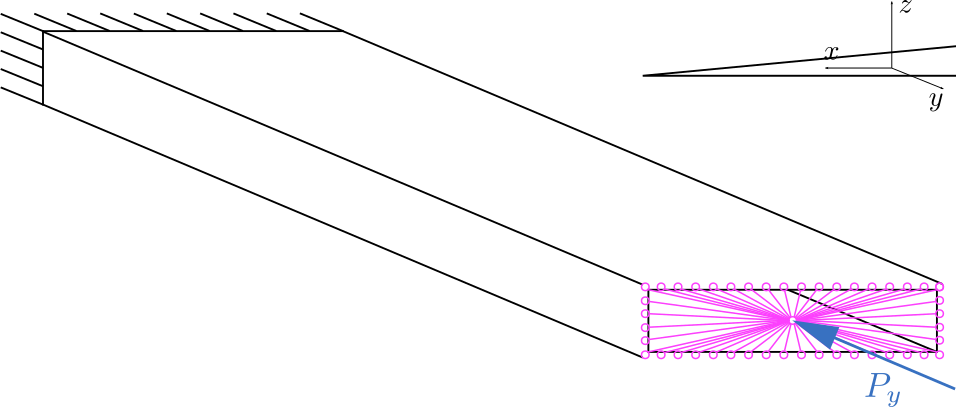

In [6]:
SVG(filename=os.path.join('resources', '11_BoxBeamCompressionLoad.svg'))

In [7]:
import numpy as np
from resources import pynastran_utils

# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
tip_nodes_ids = nodes_ids[np.abs(nodes_coordinates_array[:,1] - b) < tolerance]
# Add master node of tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
unreinforced_box_beam.add_grid(tip_section_master_node_id, [w/2, b, 0.])
# Add RBE2 to connect master node with outer nodes of tip rib
rbe2_eid = len(unreinforced_box_beam.elements) + 1
unreinforced_box_beam.add_rbe2(eid=rbe2_eid, gn=tip_section_master_node_id, cm='123456', Gmi=tip_nodes_ids)
# Add concentrated force
compression_force_set_id = 11
compression_force_direction = [0., -1., 0.]
pynastran_utils.add_unitary_force(bdf_object=unreinforced_box_beam, nodes_ids=[tip_section_master_node_id], set_id=compression_force_set_id, direction_vector=compression_force_direction)

### Linear buckling analysis <a name="unreinforced-linear-buckling"></a>

We use SOL 105 to calculate the linear buckling load and the corresponding buckling shape, in order to have a reference for the nonlinear analysis.

Buckling load: 59049 N
Buckling mode:


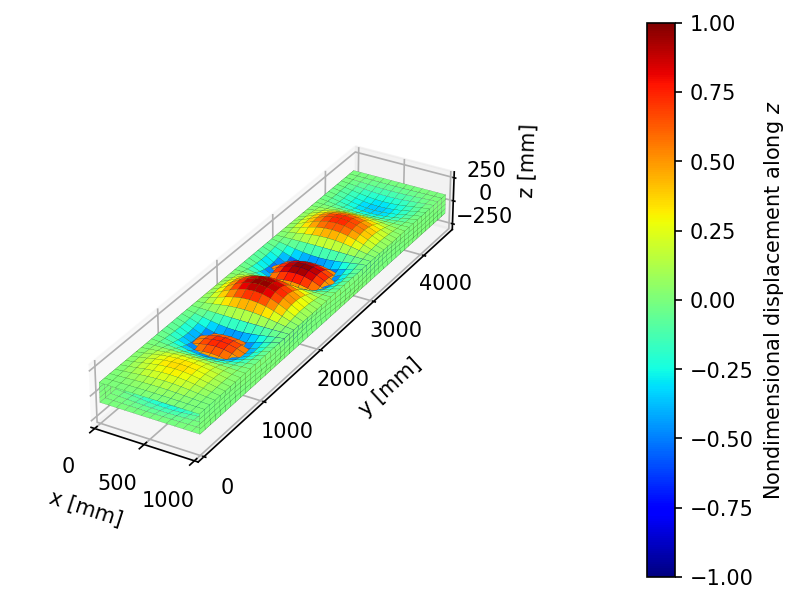

In [8]:
import matplotlib.pyplot as plt

# Define name of analysis directory
analysis_directory_name = '11_Equilibrium_Diagram_of_a_Box_Beam_Under_Uniaxial_Compression'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Calculate linear buckling load and plot buckling shape
plt.rcParams['figure.dpi'] = 150  # set default dpi of figures
sol_105_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=unreinforced_box_beam.__deepcopy__({}), static_load_set_id=compression_force_set_id, analysis_directory_path=analysis_directory_path, input_name='unreinforced_box_beam_linear_bukling', run_flag=False, plot_shape=True, displacement_component='tz')

We observe that the shape of the first buckling mode predicted by SOL 105 is characterized by six alternating waves over each skin with a top-down symmetry.

### Nonlinear analysis <a name="unreinforced-nonlinear-analysis"></a>

Now we move on to the nonlinear analysis, which we are going to use to prove the existence of a bifurcation in the equilibrium diagram of the box beam.

We start by setting up our `BDF` object for a nonlinear analysis with the full Newton method. For this we use the function `set_up_newton_method` from the `pynastran_utils` module. This function assigns SOL 106 as solution sequence and adds a NLPARM card with the input nonlinear analysis parameters. We also another NLPARM card and a NLPCI card to define a nonlinear iteration strategy employing the arc-length method. We are going to use the arc-length method only for the first subcase, corresponding to the only unstable branch of the bifurcation that we are going to explore, while for the other subcases we need the Newton method because the arc-length method in Nastran has issues when trying to change the load application direction between successive subcases. All the nonlinear parameters are taken from the results of a [previous sensitivity study](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb#nonlinear-analysis-parameters).

In [9]:
# Set up nonlinear analysis with full Newton method
no_increments = 100
load_tolerance = 1e-3
energy_tolerance = 1e-7
pynastran_utils.set_up_newton_method(bdf_object=unreinforced_box_beam, ninc=no_increments, eps_p=load_tolerance, eps_w=energy_tolerance)
# Add cards for arc-length method
nlparm_id = 2
unreinforced_box_beam.add_nlparm(nlparm_id=nlparm_id, ninc=no_increments, kmethod='ITER', kstep=1, int_out='YES', eps_p=load_tolerance, eps_w=energy_tolerance)
unreinforced_box_beam.add_nlpci(nlpci_id=nlparm_id, Type='CRIS', maxalr=1.1, desiter=5, mxinc=100)

NLPCI          2    CRIS     .25     1.1      0.               5     100

To explore the bifurcation in the equilibrium diagram we need to add an imperfection to our structure. Similarly to the case of the [Euler's column](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) and of the [thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb), we implement the imperfection adding a vertical force at the center of the top skin.

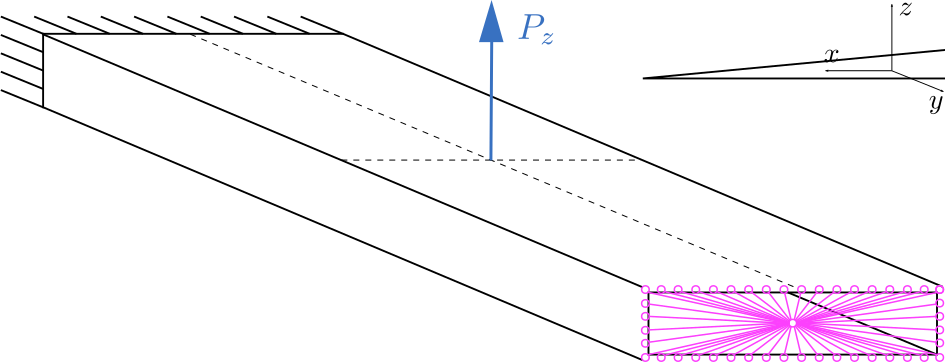

In [10]:
SVG(filename=os.path.join('resources', '11_BoxBeamEccentricLoad.svg'))

In [11]:
# Add eccentric force
eccentric_force_application_node_id = np.argmin(np.apply_along_axis(np.linalg.norm, 1, nodes_coordinates_array - np.array([w/2, b/2, h/2]))) + 1
eccentric_force_set_id = compression_force_set_id + 1
eccentric_force_direction = [0., 0., 1.]
pynastran_utils.add_unitary_force(bdf_object=unreinforced_box_beam, nodes_ids=[eccentric_force_application_node_id], set_id=eccentric_force_set_id, direction_vector=eccentric_force_direction)

Now we need to define our subcase sequence. We expect to find three branches departing from the bifurcation point, one unstable and two stable, so our strategy will be to explore one branch at a time.

1. In the first subcase we explore the unstable branch of the bifurcation and for this reason we apply only the compression load $P_y$ with a magnitude $P_y/P_{\text{SOL 105}}=1.5$, where $P_{\text{SOL 105}}$ is the buckling load predicted by SOL 105.
2. In subcase 2 we unload the structure.
3. Since we cannot directly explore the stable branches, we use the third subcase as an intermediate step by applying a combined compression and vertical load, with $P_y/P_{\text{SOL 105}}=1.5$ and $P_z/P_{\text{SOL 105}}=1/100$.
4. In the fourth subcase we remove the vertical load and we leave only the compression load. We expect this to result in a different displacement state with respect to the one resulting from subcase 1.
5. In subcase 5 we completely unload the structure, in order to walk the stable branch of the bifurcation "backwards" to the critical point and then to the undeformed state of the structure.
6. Similarly to subcase 3, the sixth subcase is an intermediate step to explore the other stable branch of the bifurcation. We apply the same load combination of subcase 3, but with the vertical load in the opposite direction.
7. In subcase 7 we remove the vertical load and we expect to find the opposite displacement state found at the end of subcase 4, so with inverted upwards-downwards displacements.
8. In the eight and last subcase we completely unload the structure to track the stable branch.


In [12]:
# Subcase 1
compression_load_set_id = 21
compression_load_magnitude = sol_105_buckling_load*1.5
unreinforced_box_beam.add_load(sid=compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude], load_ids=[compression_force_set_id])
subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=compression_load_set_id)
unreinforced_box_beam.case_control_deck.subcases[subcase_id].add_integer_type('NLPARM', nlparm_id)
# Subcase 2
zero_load_set_id = compression_load_set_id + 1
unreinforced_box_beam.add_load(sid=zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[compression_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=zero_load_set_id)
# Subcase 3
eccentric_compression_load_set_id = zero_load_set_id + 1
eccentric_load_magnitude = sol_105_buckling_load/100
unreinforced_box_beam.add_load(sid=eccentric_compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude, eccentric_load_magnitude], load_ids=[compression_force_set_id, eccentric_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=eccentric_compression_load_set_id)
# Subcase 4
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=compression_load_set_id)
# Subcase 5
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=zero_load_set_id)
# Subcase 6
opposite_eccentric_compression_load_set_id = eccentric_compression_load_set_id + 1
unreinforced_box_beam.add_load(sid=opposite_eccentric_compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude, -1*eccentric_load_magnitude], load_ids=[compression_force_set_id, eccentric_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=opposite_eccentric_compression_load_set_id)
# Subcase 7
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=compression_load_set_id)
# Subcase 8
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=zero_load_set_id)

Let's run the analysis and let's plot the deformation of our box beam at the end of each subcase.

Nastran job unreinforced_box_beam_nonlinear_analysis.bdf completed
Wall time: 309.0 s


Subcase 1


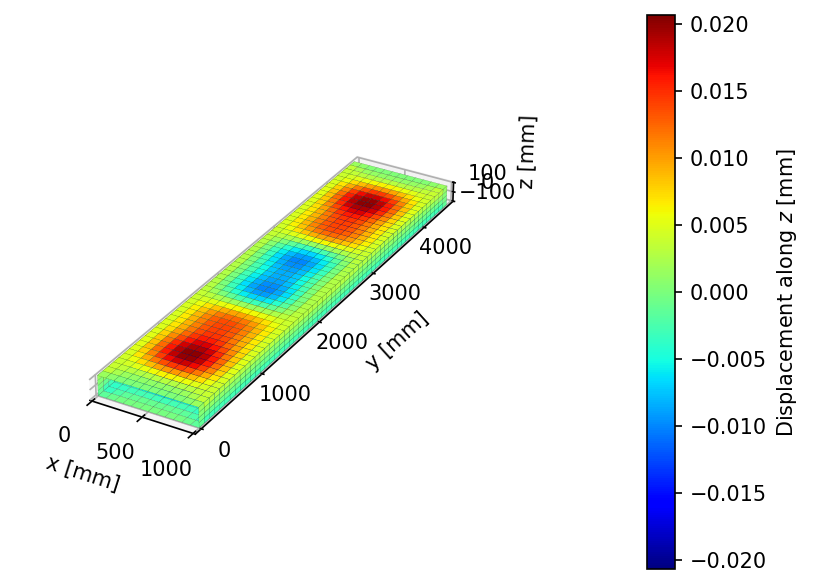

Subcase 2


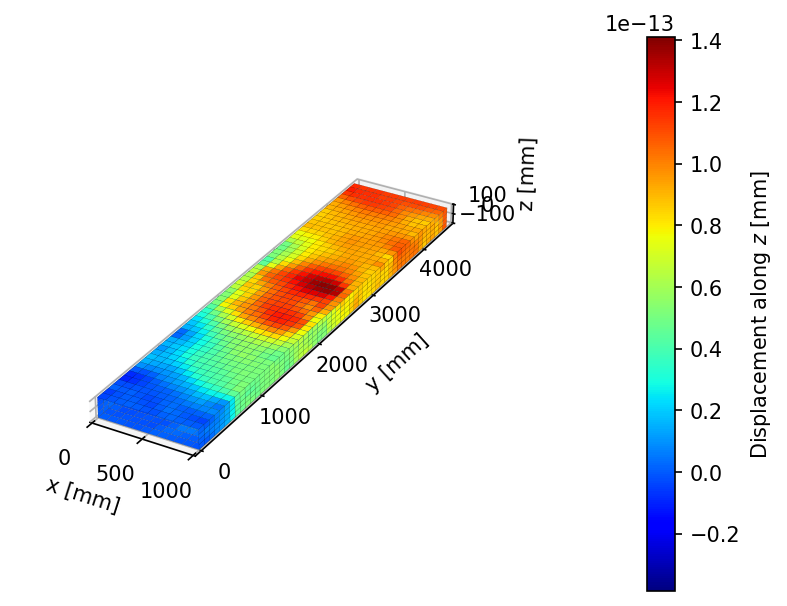

Subcase 3


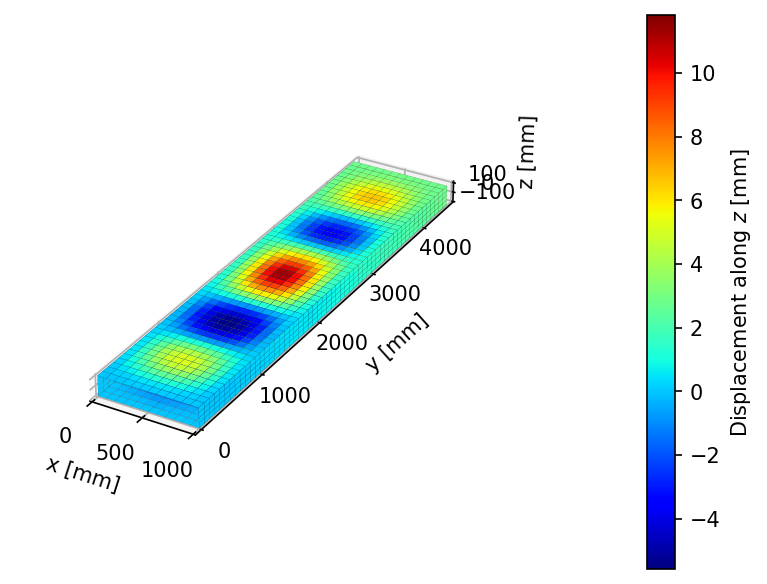

Subcase 4


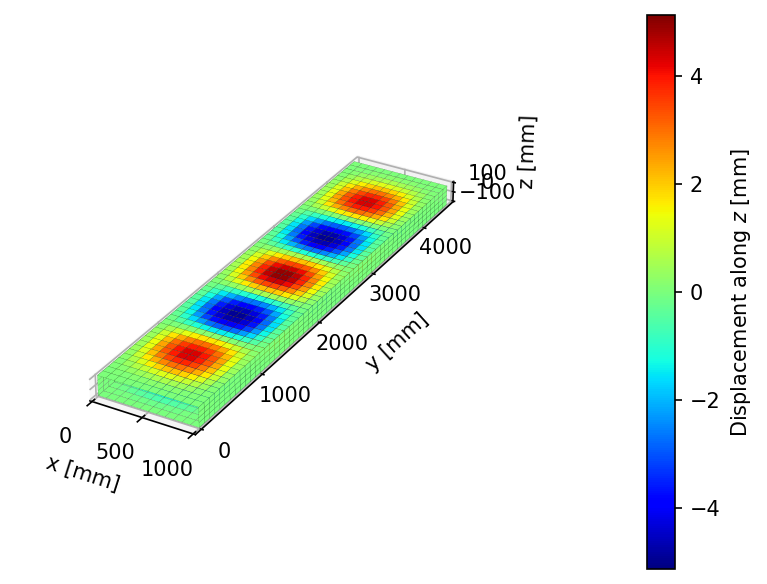

Subcase 5


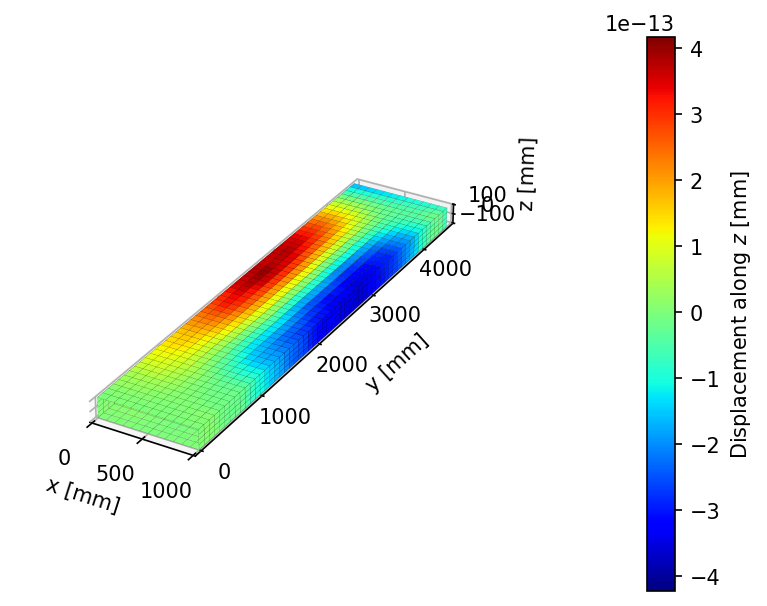

Subcase 6


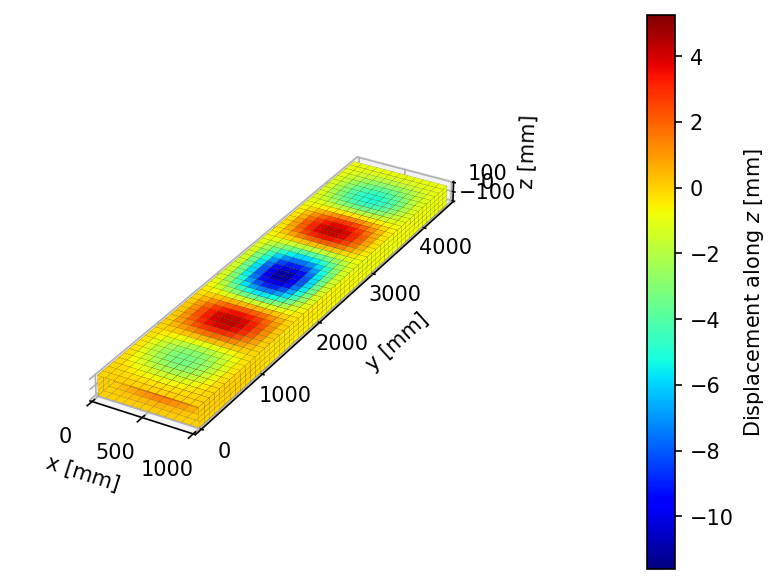

Subcase 7


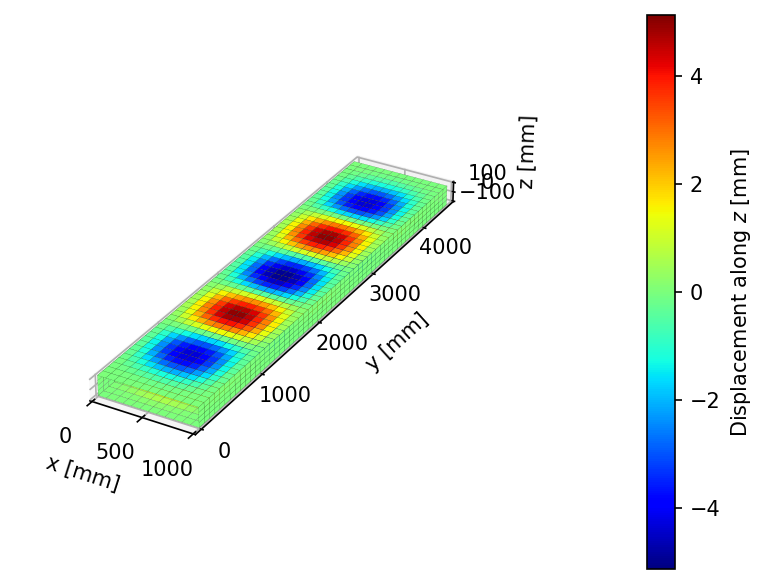

Subcase 8


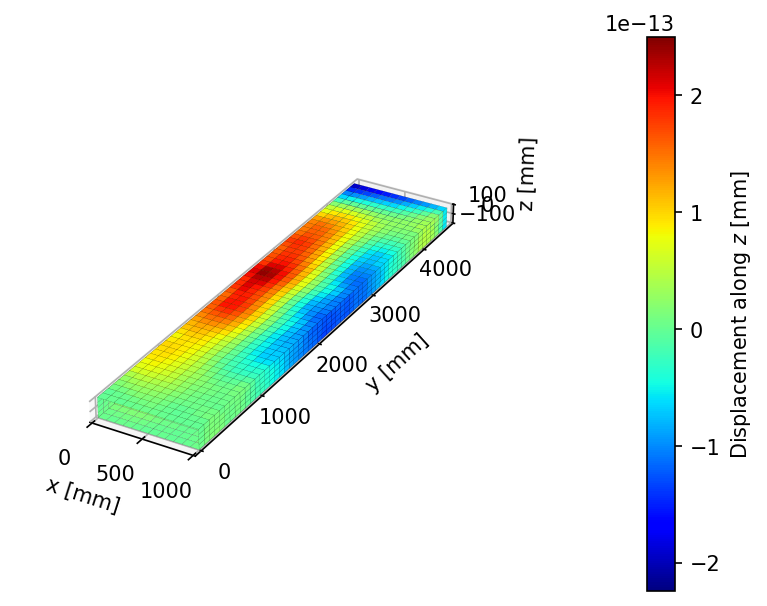

In [13]:
from pyNastran.op2.op2 import read_op2

# Run analysis
input_filename = 'unreinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=unreinforced_box_beam, filename=input_filename, run_flag=False)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=False)
# Iterate through subcases
for i in range(1, subcase_id + 1):
    # Plot static deformation at the end of the subcase
    print(f'\033[1mSubcase {i:.0f}')
    _, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=i, displacement_component='tz')
    # Adjust number of ticks of x and z axes
    ax.locator_params(axis='x', nbins=3)
    ax.locator_params(axis='z', nbins=2)
    # Adjust ticks label of y and z axes
    ax.tick_params(axis='y', which='major', pad=20)
    ax.tick_params(axis='z', which='major', pad=6)
    # Adjust axis label y and z axes
    ax.yaxis.labelpad = 60
    ax.zaxis.labelpad = 10
    # Show plot
    plt.show()

The displacement field obtained at the end of subcases 1, 4 and 7 is different, so we conclude that there must be a bifurcation in the equilibrium diagram of our box beam. We visualize the equilibrium diagram in terms of $P_y/P_{\text{SOL 105}}$, $P_z/P_{\text{SOL 105}}$ and the displacement along $z$ of a given node of the top skin. We choose to monitor the vertical displacement at a node that is approximately at the center of the first blob observed for subcases 4 and 7 looking from the root of the box beam. Similarly to our investigation on [Euler's column](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) and on the [thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb), we visualize the equilibrium diagram with both 2D and 3D plots.

Subcase 1 displacement: 0.02 mm
Subcase 2 displacement: 0.00 mm
Subcase 3 displacement: 4.93 mm
Subcase 4 displacement: 4.49 mm
Subcase 5 displacement: 0.00 mm
Subcase 6 displacement: -3.31 mm
Subcase 7 displacement: -4.48 mm
Subcase 8 displacement: 0.00 mm


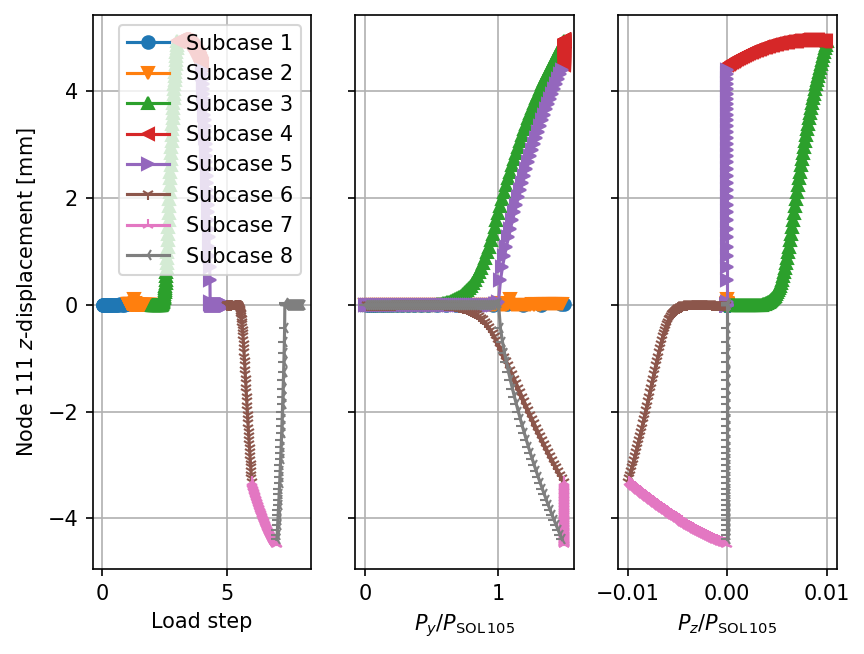

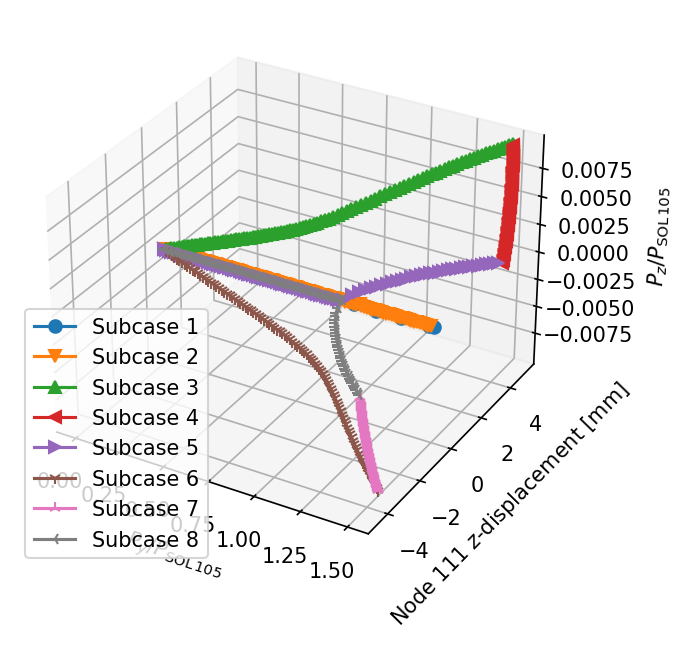

In [14]:
from matplotlib.lines import Line2D  # module including the list of all markers available in matplotlib

# Prescribe y position of monitor node
monitor_node_y = 640  # [mm]
# Find the closest node to the prescribed position
monitor_node_id = np.argmin(np.apply_along_axis(np.linalg.norm, 1, nodes_coordinates_array - np.array([w/2, monitor_node_y, h/2]))) + 1
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=monitor_node_id)
# Store list of matplotlib markers
markers = list(Line2D.markers.keys())[2:]
# Create figure with subplots
_, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
# Iterate over the subcases
for id in range(1, subcase_id + 1):
    # Save vertical displacement
    vertical_displacement = displacements[id][:, 2]
    # Print rotation at the end of subcase
    print(f'Subcase {id:d} displacement: {vertical_displacement[-1]:.2f} mm')
    # Plot load step vs displacement
    axs[0].plot(load_steps[id], vertical_displacement, markers[id - 1] + '-', label=f'Subcase {id:d}')
    # Plot applied load along y vs rotation
    axs[1].plot(-applied_loads[id][:,1]/sol_105_buckling_load, vertical_displacement, markers[id - 1] + '-')  # sign of load along y is inverted to show a positive load in the plot
    # Plot applied load along z vs displacement
    axs[2].plot(applied_loads[id][:,2]/sol_105_buckling_load, vertical_displacement, markers[id - 1] + '-')
# Set plot appearance
axs[0].set_xlabel('Load step')
axs[0].set_ylabel(f'Node {monitor_node_id:d} $z$-displacement [mm]')
axs[0].grid(visible=True)
axs[1].set_xlabel(r'$P_y/P_{\mathrm{SOL\/105}}$')
axs[1].grid(visible=True)
axs[2].set_xlabel(r'$P_z/P_{\mathrm{SOL\/105}}$')
axs[2].grid(visible=True)
axs[0].legend()
# Show plot
plt.show()
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')
# Plot applied load along y vs displacement vs applied load along z
for id in displacements:
    ax_3d.plot3D(-applied_loads[id][:,1]/sol_105_buckling_load, displacements[id][:,2], applied_loads[id][:,2]/sol_105_buckling_load, markers[id - 1] + '-', label=f'Subcase {id:d}')  # sign of load along y is inverted to show a positive load in the plot
ax_3d.set_xlabel(r'$P_y/P_{\mathrm{SOL\/105}}$')
ax_3d.set_ylabel(f'Node {monitor_node_id:d} $z$-displacement [mm]')
ax_3d.set_zlabel(r'$P_z/P_{\mathrm{SOL\/105}}$')
ax_3d.legend()
ax_3d.grid(visible=True)
ax_3d.tick_params(axis='z', which='major', pad=8)
ax_3d.zaxis.labelpad = 15
# Show plot
plt.show()

The results shown above demonstrate the presence of a pitchfork bifurcation.

## Reinforced box beam <a name="reinforced"></a>

***

### Setup of the numerical model <a name="reinforced-numerical-model"></a>

We consider the same geometry and material properties of the unreinforced box beam and we define the ribs with a spacing of $w/2$.

In [15]:
# Prescribed spacing
ribs_spacing = w/2
# Number of ribs based on prescribed spacing
no_ribs = int(np.ceil(b/ribs_spacing)) + 1
print(f'Number of ribs: {no_ribs:d}')
# Find prescribed ribs location
ribs_y_locations = np.linspace(0, b, no_ribs)
print('Ribs y position [mm]:')
np.set_printoptions(precision=0)
print(ribs_y_locations)

Number of ribs: 10
Ribs y position [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


We create a mesh of quadrilateral elements using the function `mesh_box_beam_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 49 mm based on the results of a previous [mesh convergence study](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb#mesh-convergence).

In [16]:
edge_length = 49  # [mm]
reinforced_box_beam_mesh = box_beam_utils.mesh_box_beam_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=edge_length)
nodes_coordinates_array = reinforced_box_beam_mesh.points
nodes_connectivity_matrix = reinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Successively we create a base `BDF` object where we define fixed boundary conditions at the root of the box beam.

In [17]:
# Create BDF object
reinforced_box_beam = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Print cards of BDF object
print(reinforced_box_beam.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 7154

bdf.elements: 0
  CQUAD4   : 7368

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Let's apply the same compression force used for the unreinforced box beam. This time we use a RBE3 element to connect the nodes along the outer edges of the tip section to the node in the center as the rigidity of the tip is enforced by the presence of a physical rib.

In [18]:
# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
outer_tip_nodes_ids = nodes_ids[(np.abs(nodes_coordinates_array[:, 1] - b) < tolerance) & ((nodes_coordinates_array[:, 0] < tolerance) | (np.abs(nodes_coordinates_array[:, 0] - w) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] - h/2) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] + h/2) < tolerance))]  # nodes along the edges of the tip section
# Add master node of tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
reinforced_box_beam.add_grid(tip_section_master_node_id, [w/2, b, 0.])
# Add RBE2 to connect master node with outer nodes of tip rib
rbe3_eid = len(reinforced_box_beam.elements) + 1
reinforced_box_beam.add_rbe3(eid=rbe3_eid, refgrid=tip_section_master_node_id, refc='123456', weights=[1.]*len(outer_tip_nodes_ids), comps=['123456']*len(outer_tip_nodes_ids), Gijs=outer_tip_nodes_ids)
# Add concentrated force
compression_force_set_id = 11
pynastran_utils.add_unitary_force(bdf_object=reinforced_box_beam, nodes_ids=[tip_section_master_node_id], set_id=compression_force_set_id, direction_vector=compression_force_direction)

### Linear buckling analysis <a name="reinforced-linear-buckling"></a>

We use SOL 105 to calculate the linear buckling load and the corresponding buckling shape, in order to have a reference for the nonlinear analysis.

Nastran job reinforced_box_beam_linear_bukling.bdf completed
Wall time: 3.0 s


Buckling load: 105009 N
Buckling mode:


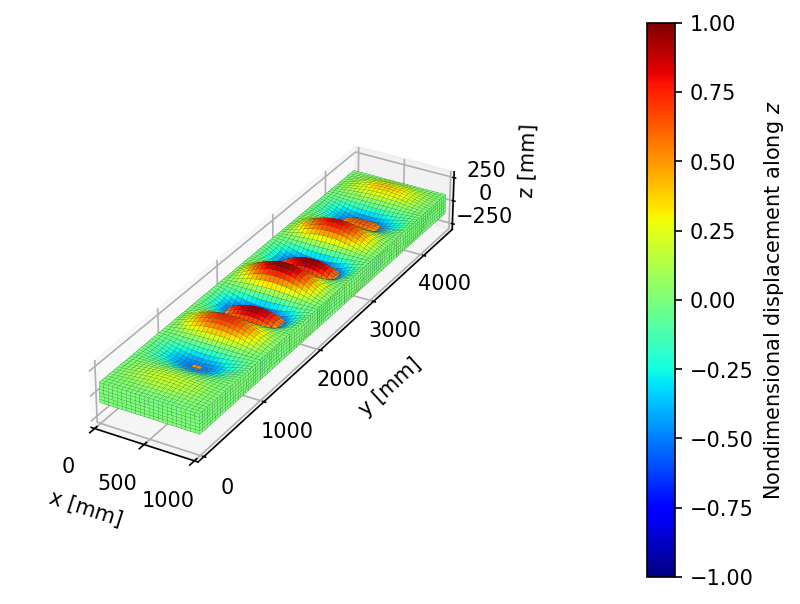

In [19]:
sol_105_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=reinforced_box_beam.__deepcopy__({}), static_load_set_id=compression_force_set_id, analysis_directory_path=analysis_directory_path, input_name='reinforced_box_beam_linear_bukling', run_flag=False, plot_shape=True, displacement_component='tz')

As expected, the buckling load of the reinforced configuration is larger than the one of the unreinforced configuration. Besides, the first buckling mode consists of nine alternating waves over each skin, corresponding to one for each rib bay.

### Nonlinear analysis <a name="reinforced-nonlinear-analysis"></a>

Also for the reinforced configuration we want to show the existence of a bifurcation in the equilibrium diagram. As a consequence, we set up the nonlinear analysis, the vertical force and the subcase sequence in the same way as done for the unreinforced configuration.

In [20]:
# Set up nonlinear analysis with full Newton method
pynastran_utils.set_up_newton_method(bdf_object=reinforced_box_beam, ninc=no_increments, eps_p=load_tolerance, eps_w=energy_tolerance)
# Add cards for arc-length method
nlparm_id = 2
reinforced_box_beam.add_nlparm(nlparm_id=nlparm_id, ninc=no_increments, kmethod='ITER', kstep=1, int_out='YES', eps_p=load_tolerance, eps_w=energy_tolerance)
reinforced_box_beam.add_nlpci(nlpci_id=nlparm_id, Type='CRIS', maxalr=1.1, desiter=5, mxinc=100)
# Add eccentric force
eccentric_force_application_node_id = np.argmin(np.apply_along_axis(np.linalg.norm, 1, nodes_coordinates_array - np.array([w/2, b/2, h/2]))) + 1
pynastran_utils.add_unitary_force(bdf_object=reinforced_box_beam, nodes_ids=[eccentric_force_application_node_id], set_id=eccentric_force_set_id, direction_vector=eccentric_force_direction)
# Subcase 1
compression_load_magnitude = sol_105_buckling_load*1.5
reinforced_box_beam.add_load(sid=compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude], load_ids=[compression_force_set_id])
subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=compression_load_set_id)
reinforced_box_beam.case_control_deck.subcases[subcase_id].add_integer_type('NLPARM', nlparm_id)
# Subcase 2
reinforced_box_beam.add_load(sid=zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[compression_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=zero_load_set_id)
# Subcase 3
eccentric_load_magnitude = sol_105_buckling_load/100
reinforced_box_beam.add_load(sid=eccentric_compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude, eccentric_load_magnitude], load_ids=[compression_force_set_id, eccentric_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=eccentric_compression_load_set_id)
# Subcase 4
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=compression_load_set_id)
# Subcase 5
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=zero_load_set_id)
# Subcase 6
reinforced_box_beam.add_load(sid=opposite_eccentric_compression_load_set_id, scale=1., scale_factors=[compression_load_magnitude, -1*eccentric_load_magnitude], load_ids=[compression_force_set_id, eccentric_force_set_id])
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=opposite_eccentric_compression_load_set_id)
# Subcase 7
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=compression_load_set_id)
# Subcase 8
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=zero_load_set_id)

We run the analysis and once again plot the deformation at the end of each subcase.

Nastran job reinforced_box_beam_nonlinear_analysis.bdf completed
Wall time: 1569.0 s


Subcase 1


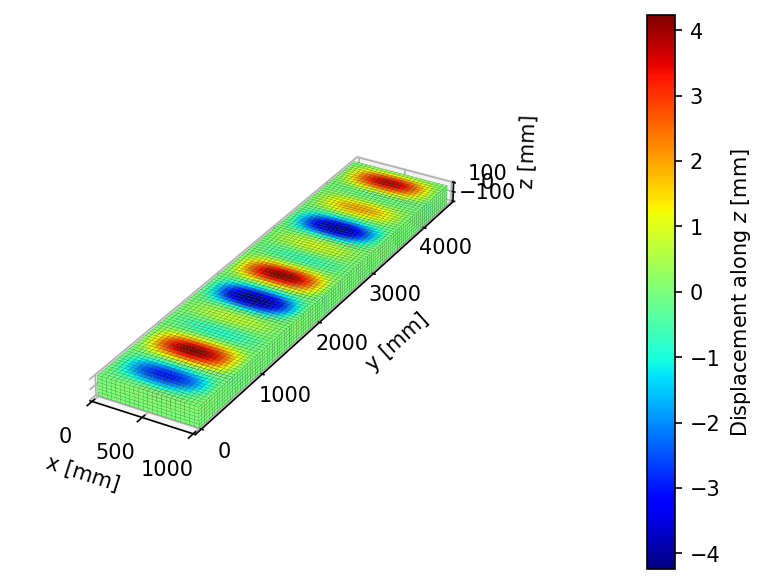

Subcase 2


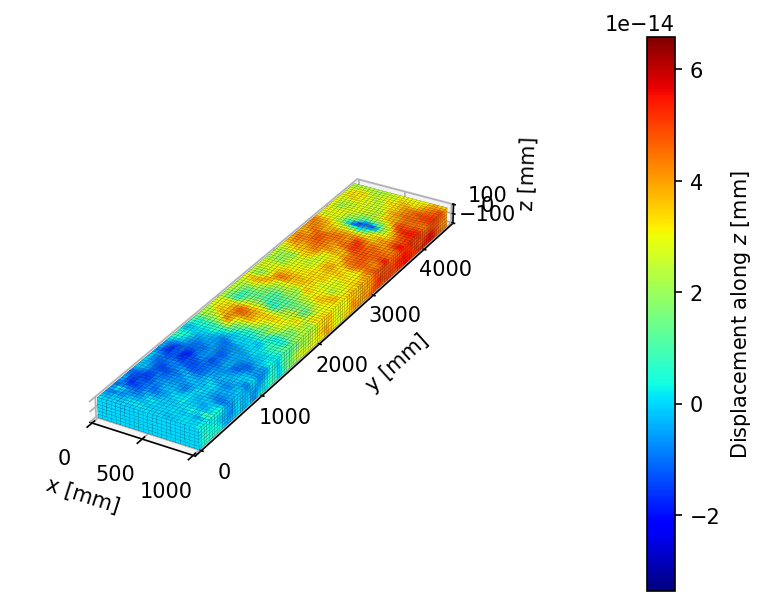

Subcase 3


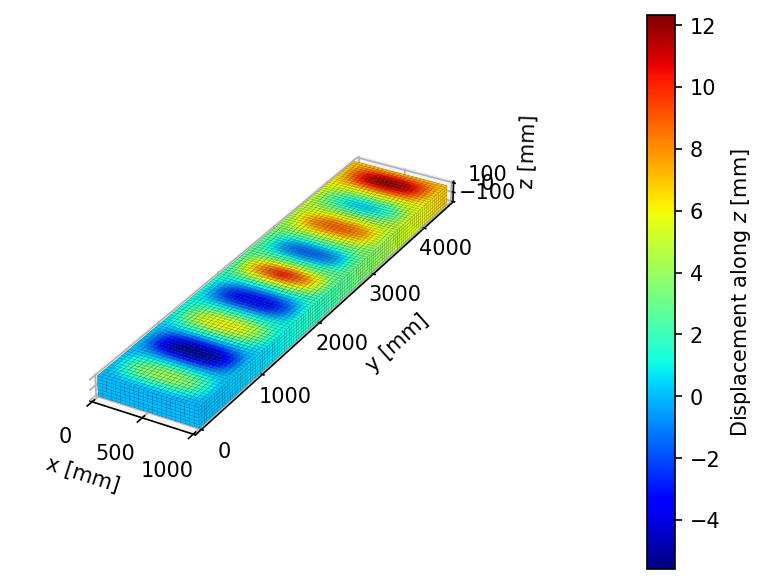

Subcase 4


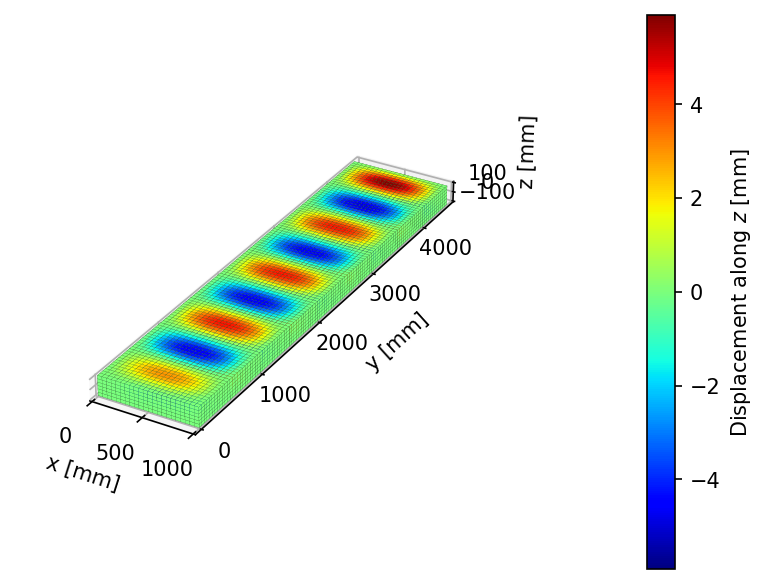

Subcase 5


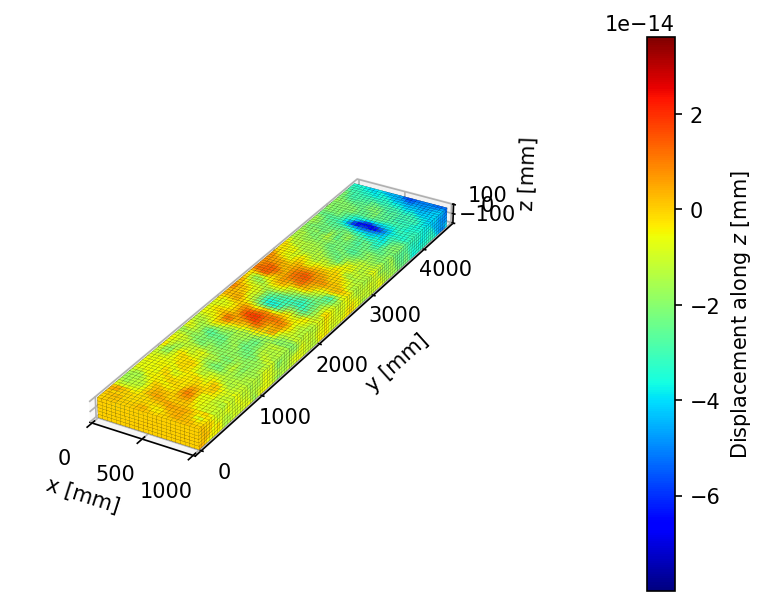

Subcase 6


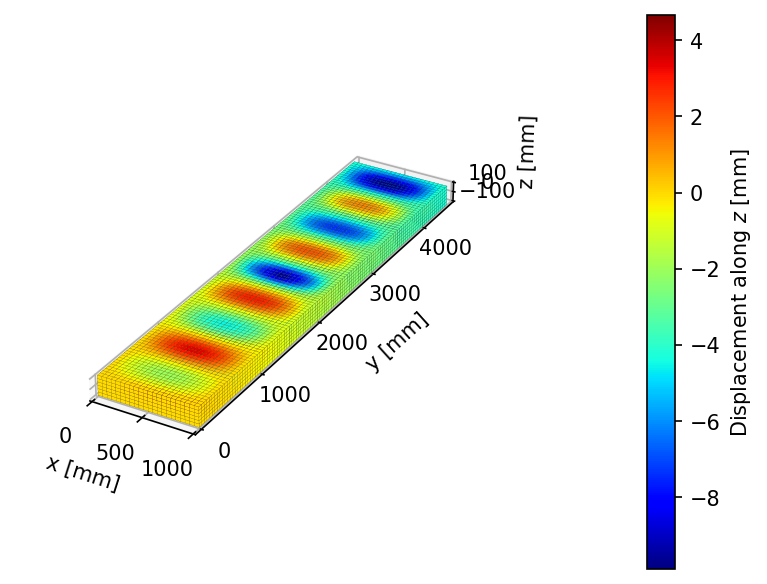

Subcase 7


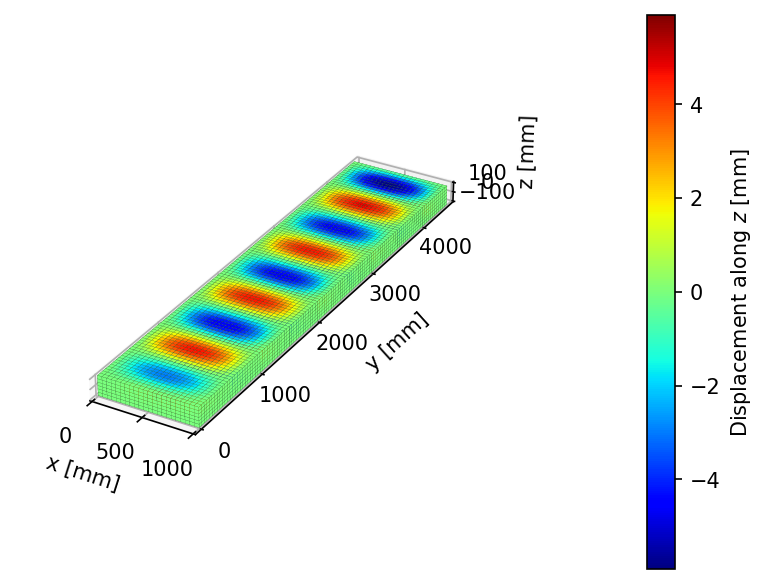

Subcase 8


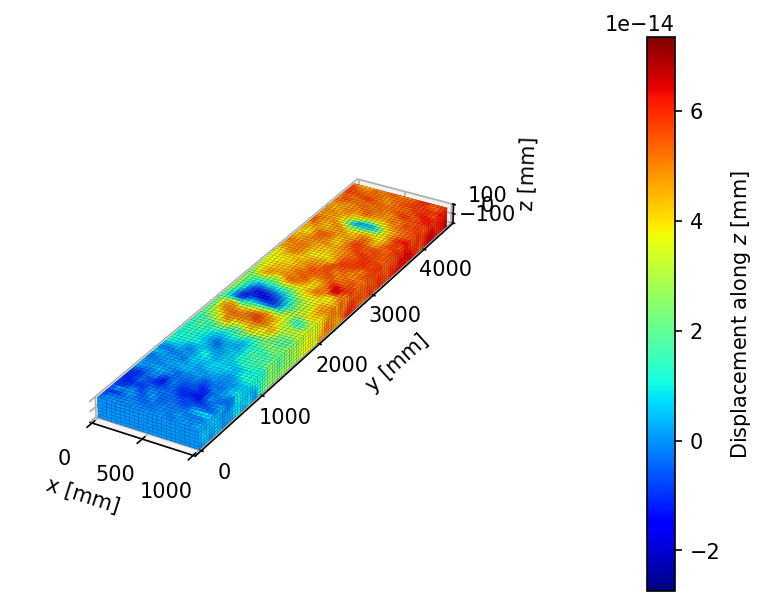

In [21]:
# Run analysis
input_filename = 'reinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=reinforced_box_beam, filename=input_filename, run_flag=False)
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=False)
# Iterate through subcases
for i in range(1, subcase_id + 1):
    # Plot static deformation at the end of the subcase
    print(f'\033[1mSubcase {i:.0f}')
    _, ax = pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=i, displacement_component='tz')
    # Adjust number of ticks of x and z axes
    ax.locator_params(axis='x', nbins=3)
    ax.locator_params(axis='z', nbins=2)
    # Adjust ticks label of y and z axes
    ax.tick_params(axis='y', which='major', pad=20)
    ax.tick_params(axis='z', which='major', pad=6)
    # Adjust axis label y and z axes
    ax.yaxis.labelpad = 60
    ax.zaxis.labelpad = 10
    # Show plot
    plt.show()

Once again, we can observe a different displacement field at the end of subcases 1, 4 and 7 is different. As a consequence, also for the reinforced box beam there must be a bifurcation in its equilibrium diagram. Let's plot it in an analogous way as done for the unreinforced box beam. Also here we want to monitor the vertical displacement at the node that is approximately at the center of the first blob observed in subcases 4 and 7 looking from the root of the box beam, so we change the queried $y$ coordinate accordingly.

Subcase 1 displacement: -2.91 mm
Subcase 2 displacement: -0.00 mm
Subcase 3 displacement: 4.05 mm
Subcase 4 displacement: 2.87 mm
Subcase 5 displacement: 0.00 mm
Subcase 6 displacement: -2.06 mm
Subcase 7 displacement: -2.88 mm
Subcase 8 displacement: -0.00 mm


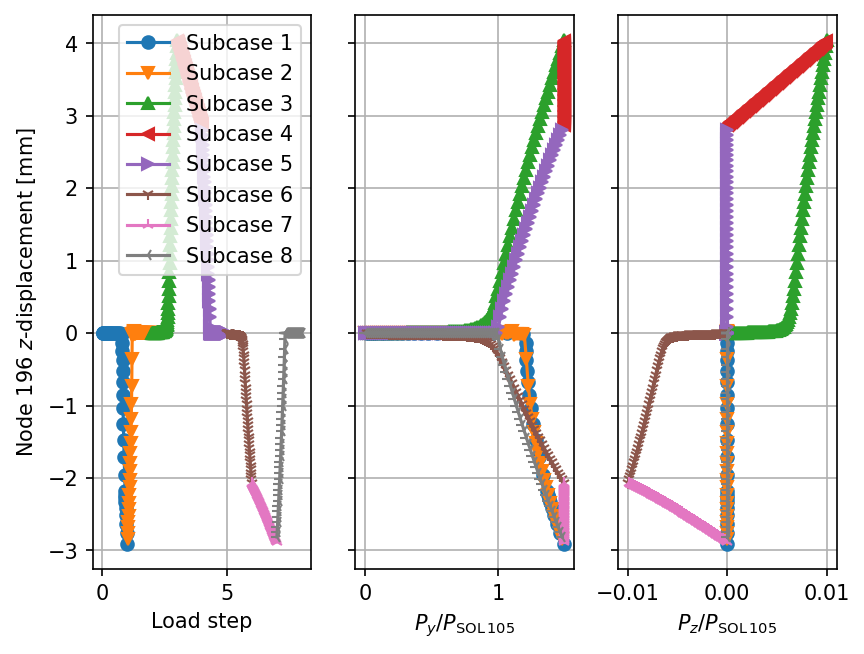

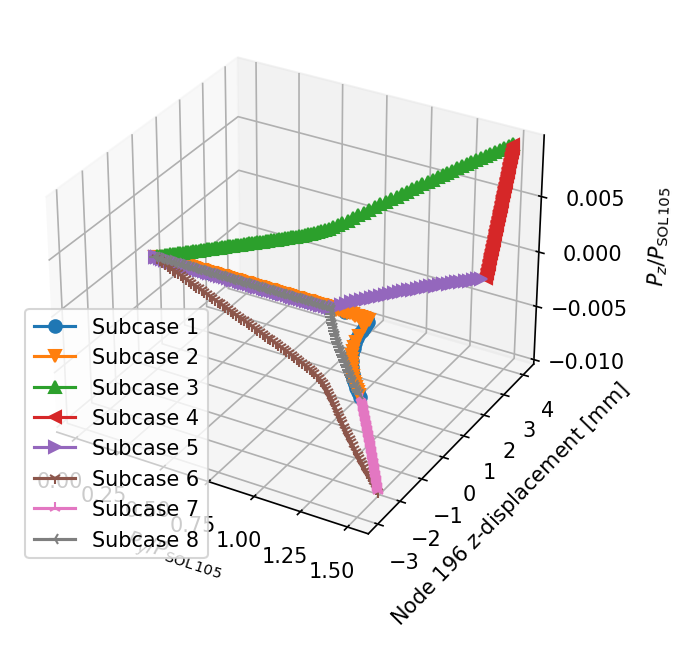

In [22]:
# Prescribe y position of monitor node
monitor_node_y = 320  # [mm]
# Find the closest node to the prescribed position
monitor_node_id = np.argmin(np.apply_along_axis(np.linalg.norm, 1, nodes_coordinates_array - np.array([w/2, monitor_node_y, h/2]))) + 1
# Read load displacement history
load_steps, applied_loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=monitor_node_id)
# Store list of matplotlib markers
markers = list(Line2D.markers.keys())[2:]
# Create figure with subplots
_, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
# Iterate over the subcases
for id in range(1, subcase_id + 1):
    # Save vertical displacement
    vertical_displacement = displacements[id][:, 2]
    # Print rotation at the end of subcase
    print(f'Subcase {id:d} displacement: {vertical_displacement[-1]:.2f} mm')
    # Plot load step vs displacement
    axs[0].plot(load_steps[id], vertical_displacement, markers[id - 1] + '-', label=f'Subcase {id:d}')
    # Plot applied load along y vs rotation
    axs[1].plot(-applied_loads[id][:,1]/sol_105_buckling_load, vertical_displacement, markers[id - 1] + '-')  # sign of load along y is inverted to show a positive load in the plot
    # Plot applied load along z vs displacement
    axs[2].plot(applied_loads[id][:,2]/sol_105_buckling_load, vertical_displacement, markers[id - 1] + '-')
# Set plot appearance
axs[0].set_xlabel('Load step')
axs[0].set_ylabel(f'Node {monitor_node_id:d} $z$-displacement [mm]')
axs[0].grid(visible=True)
axs[1].set_xlabel(r'$P_y/P_{\mathrm{SOL\/105}}$')
axs[1].grid(visible=True)
axs[2].set_xlabel(r'$P_z/P_{\mathrm{SOL\/105}}$')
axs[2].grid(visible=True)
axs[0].legend()
# Show plot
plt.show()
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection='3d')
# Plot applied load along y vs displacement vs applied load along z
for id in displacements:
    ax_3d.plot3D(-applied_loads[id][:,1]/sol_105_buckling_load, displacements[id][:,2], applied_loads[id][:,2]/sol_105_buckling_load, markers[id - 1] + '-', label=f'Subcase {id:d}')  # sign of load along y is inverted to show a positive load in the plot
ax_3d.set_xlabel(r'$P_y/P_{\mathrm{SOL\/105}}$')
ax_3d.set_ylabel(f'Node {monitor_node_id:d} $z$-displacement [mm]')
ax_3d.set_zlabel(r'$P_z/P_{\mathrm{SOL\/105}}$')
ax_3d.legend()
ax_3d.grid(visible=True)
ax_3d.tick_params(axis='z', which='major', pad=8)
ax_3d.zaxis.labelpad = 15
# Show plot
plt.show()

The results show a pitchfork bifurcation at $P_y/P_{\text{SOL 105}}=1$. We can also partially observe another bifurcation at about $P_y/P_{\text{SOL 105}}=1.2$, as the branch represented by the first subcase departs from the zero-displacement line.

## Conclusions <a name="conclusions"></a>

***

In this notebook we have demonstrated the appearance of a bifurcation when we apply a compression load rather than a bending load to the box beam. As a consequence we can conclude that the asymmetry introduced by the bending load is responsible for the bifurcation break observed in previous notebooks.

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [23]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()